### LightGBMを試す


In [1]:
import numpy as np
import pandas as pd
import gc
import os
import time
import random
from tqdm.auto import tqdm
import datetime
import dask.dataframe as dd

In [2]:
def visualize_df(df):
    print(df.shape)
    display(df.head())

## Read Data

In [3]:
input_type = {
 'customer_id':                 'int64',
 'article_id':                  'int32',
 'label':                       'bool',
 'FN':                          'bool',
 'Active':                      'bool',
 'club_member_status':          'int8',
 'fashion_news_frequency':      'int8',
 'age':                         'int8',
 'a_mean_age':                  'int8',
 'a_std_age':                   'float16',
 'postal_code':                 'int32',   
 'product_code':                'int32',  
 'product_type_no':             'int32',
 'graphical_appearance_no':     'int32',
 'colour_group_code':           'int32',
 'perceived_colour_value_id':   'int32',
 'perceived_colour_master_id':  'int32',
 'department_no':               'int16',
 'index_code':                  'int16',
 'index_group_no':              'int8',
 'section_no':                  'int8',
 'garment_group_no':            'int16',
 'is_for_male':                 'bool',
 'is_for_female':               'bool',
 'is_for_mama':                 'bool',
 'c_mean_price':                'float16',
 'c_std_price':                 'float16',
 'a_mean_price':                'float16',     
 'c_cv_total':                  'int32',
 'a_cv_total':                  'int32', 
 'c_cv_recent':                 'int32',
 'a_cv_recent':                 'int32',
 'c_mean_sales_channel_id':     'float16',
 'a_mean_sales_channel_id':     'float16',
 'a_mean_is_for_male':          'float16',
 'a_mean_is_for_female':        'float16',
 'a_mean_is_for_mama':          'float16',
 'ca_index_group_no_num':       'int32',
 'index_group_no_similarity':   'float32',
 'ca_index_code_num':           'int32',
 'index_code_similarity':       'float32',
 'ca_product_group_no_num':     'int32',
 'product_group_no_similarity': 'float32',
 'buy_same_before':             'int16',
 'buy_same_before_recent':      'int16',
 'delta_mean_price':            'float16',
 'delta_mean_age':              'int8',
 'delta_mean_sales_channel_id': 'float16',
 'delta_mean_is_for_male':      'float16',
 'delta_mean_is_for_female':    'float16',
 'delta_mean_is_for_mama':      'float16'
 }

In [4]:
# train data
#train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09', '2020-09-16']
#train_date_list = ['2020-08-26', '2020-09-02', '2020-09-09']
#train_date_list = ['2020-09-02', '2020-09-09']
train_date_list = ['2020-09-16']
negative_num = 100
train_list = [dd.read_csv(f'./train_{date}_{negative_num}.csv', dtype=input_type).compute() for date in train_date_list]

In [5]:
train = pd.concat([train_list[0]], ignore_index=True)
#train = pd.concat([train_list[0], train_list[1]], ignore_index=True)
#train = pd.concat([train_list[0], train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[1], train_list[2]], ignore_index=True)
#train = pd.concat([train_list[2]], ignore_index=True)
#valid = train_list[3].reset_index(drop=True)

In [6]:
# 毎回同じbaselineと比較するため固定
valid = dd.read_csv(f'./train_2020-09-16_100.csv', dtype=input_type).compute() 
valid = valid.reset_index(drop=True)

In [7]:
train

,customer_id,article_id,label,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,...,ca_product_group_no_num,product_group_no_similarity,buy_same_before,buy_same_before_recent,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,-9223100958908512198,372860002,False,True,False,0,4,35,303672,0.028214,...,0,0.000000,0,0,0.016068,1,0.625977,0.000000,0.000000,0.130493
1,-9223100958908512198,557994019,False,True,False,0,4,35,303672,0.028214,...,0,0.000000,0,0,0.001570,-3,1.000000,0.000000,0.000000,0.130493
2,-9223100958908512198,564311036,False,True,False,0,4,35,303672,0.028214,...,0,0.000000,0,0,0.003237,0,1.000000,-1.000000,1.000000,0.130493
3,-9223100958908512198,579541001,False,True,False,0,4,35,303672,0.028214,...,9,0.391304,0,0,0.011978,-7,0.492188,0.000000,0.000000,0.130493
4,-9223100958908512198,600886001,False,True,False,0,4,35,303672,0.028214,...,0,0.000000,0,0,0.003975,1,0.069336,0.000000,0.000000,0.130493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6965627,9223141695752178477,926825002,False,True,True,0,4,19,135002,0.024078,...,3,0.200000,0,0,0.024078,19,1.133789,0.266602,-0.266602,0.000000
6965628,9223141695752178477,928723001,False,True,True,0,4,19,135002,0.024078,...,3,0.200000,0,0,-0.017838,-16,-0.866211,0.266602,-0.266602,0.000000
6965629,9223141695752178477,928907001,False,True,True,0,4,19,135002,0.024078,...,3,0.200000,0,0,-0.025879,-19,-0.719727,0.266602,-0.266602,0.000000
6965630,9223141695752178477,929165001,False,True,True,0,4,19,135002,0.024078,...,3,0.200000,0,0,-0.026093,-18,-0.866211,0.266602,-0.266602,0.000000


In [8]:
valid

,customer_id,article_id,label,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,...,ca_product_group_no_num,product_group_no_similarity,buy_same_before,buy_same_before_recent,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,-9223100958908512198,372860002,False,True,False,0,4,35,303672,0.028214,...,0,0.000000,0,0,0.016068,1,0.625977,0.000000,0.000000,0.130493
1,-9223100958908512198,557994019,False,True,False,0,4,35,303672,0.028214,...,0,0.000000,0,0,0.001570,-3,1.000000,0.000000,0.000000,0.130493
2,-9223100958908512198,564311036,False,True,False,0,4,35,303672,0.028214,...,0,0.000000,0,0,0.003237,0,1.000000,-1.000000,1.000000,0.130493
3,-9223100958908512198,579541001,False,True,False,0,4,35,303672,0.028214,...,9,0.391304,0,0,0.011978,-7,0.492188,0.000000,0.000000,0.130493
4,-9223100958908512198,600886001,False,True,False,0,4,35,303672,0.028214,...,0,0.000000,0,0,0.003975,1,0.069336,0.000000,0.000000,0.130493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6965627,9223141695752178477,926825002,False,True,True,0,4,19,135002,0.024078,...,3,0.200000,0,0,0.024078,19,1.133789,0.266602,-0.266602,0.000000
6965628,9223141695752178477,928723001,False,True,True,0,4,19,135002,0.024078,...,3,0.200000,0,0,-0.017838,-16,-0.866211,0.266602,-0.266602,0.000000
6965629,9223141695752178477,928907001,False,True,True,0,4,19,135002,0.024078,...,3,0.200000,0,0,-0.025879,-19,-0.719727,0.266602,-0.266602,0.000000
6965630,9223141695752178477,929165001,False,True,True,0,4,19,135002,0.024078,...,3,0.200000,0,0,-0.026093,-18,-0.866211,0.266602,-0.266602,0.000000


In [9]:
del train_list
gc.collect()

0

## Preprocess

In [10]:
train.sort_index(inplace=True)
valid.sort_index(inplace=True)
train.head()

,customer_id,article_id,label,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,...,ca_product_group_no_num,product_group_no_similarity,buy_same_before,buy_same_before_recent,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,-9223100958908512198,372860002,False,True,False,0,4,35,303672,0.028214,...,0,0.000000,0,0,0.016068,1,0.625977,0.0,0.0,0.130493
1,-9223100958908512198,557994019,False,True,False,0,4,35,303672,0.028214,...,0,0.000000,0,0,0.001570,-3,1.000000,0.0,0.0,0.130493
2,-9223100958908512198,564311036,False,True,False,0,4,35,303672,0.028214,...,0,0.000000,0,0,0.003237,0,1.000000,-1.0,1.0,0.130493
3,-9223100958908512198,579541001,False,True,False,0,4,35,303672,0.028214,...,9,0.391304,0,0,0.011978,-7,0.492188,0.0,0.0,0.130493
4,-9223100958908512198,600886001,False,True,False,0,4,35,303672,0.028214,...,0,0.000000,0,0,0.003975,1,0.069336,0.0,0.0,0.130493


In [11]:
# queryの準備, customer_idごとにsortする, lightGBMを使うときに必要
query_list_train = train['customer_id'].value_counts()
query_list_train = query_list_train.sort_index()

query_list_valid = valid['customer_id'].value_counts()
query_list_valid = query_list_valid.sort_index()

In [12]:
query_list_train.head()

-9223100958908512198    100
-9223002534477110135     97
-9222810895170663723    100
-9221924794303263774    101
-9221811157628158522    100
Name: customer_id, dtype: int64

In [13]:
# 学習データを特徴量と目的変数に分ける
train_x = train.drop(['label'], axis=1)
train_y = train['label']

valid_x = valid.drop(['label'], axis=1)
valid_y = valid['label']

In [14]:
# 特徴量作成
train_x = train_x.drop(['customer_id', 'article_id'], axis=1)
valid_x = valid_x.drop(['customer_id', 'article_id'], axis=1)

In [15]:
# labelエンコードは前段で済んでいる

## Training

In [16]:
# LightGBM
import lightgbm as lgb

params = {
    'objective': 'lambdarank',
    'metric': 'map',
    'ndcg_eval_at': [12],
    'num_leaves': 63,         # default = 31,
    'learning_rate': 0.01,    # default = 0.1
    'feature_fraction': 0.8,  # default = 1.0
    'bagging_freq': 1,        # default = 0
    'bagging_fraction': 0.8,  # default = 1.0
    'random_state': 0,        # default = None
}

num_round = 100

In [17]:
# 特徴量と目的変数をlightgbmのデータ構造に変換する
lgb_train = lgb.Dataset(train_x, train_y, group=query_list_train)
lgb_eval = lgb.Dataset(valid_x, valid_y, group=query_list_valid)

In [18]:
lgb_train

In [19]:
# 学習の実行
# バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
model = lgb.train(params, lgb_train, 
                  num_boost_round=num_round, 
                  valid_names=['train', 'valid'], 
                  valid_sets=[lgb_train, lgb_eval])

[LightGBM] [Info] Total groups: 68984, total data: 6965632
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7130
[LightGBM] [Info] Number of data points in the train set: 6965632, number of used features: 49
[LightGBM] [Info] Total groups: 68984, total data: 6965632
[1]	train's map@12: 0.103941	valid's map@12: 0.103941
[2]	train's map@12: 0.114778	valid's map@12: 0.114778
[3]	train's map@12: 0.126588	valid's map@12: 0.126588
[4]	train's map@12: 0.13322	valid's map@12: 0.13322
[5]	train's map@12: 0.137756	valid's map@12: 0.137756
[6]	train's map@12: 0.139904	valid's map@12: 0.139904
[7]	train's map@12: 0.142165	valid's map@12: 0.142165
[8]	train's map@12: 0.143808	valid's map@12: 0.143808
[9]	train's map@12: 0.145971	valid's map@12: 0.145971
[10]	train's map@12: 0.147085	valid's ma

In [20]:
model.feature_importance

<bound method Booster.feature_importance of <lightgbm.basic.Booster object at 0x7fc492e680d0>>

In [21]:
model.best_iteration

0

In [22]:
model.feature_name()

['FN',
 'Active',
 'club_member_status',
 'fashion_news_frequency',
 'age',
 'postal_code',
 'c_mean_price',
 'c_std_price',
 'c_cv_total',
 'c_cv_recent',
 'c_mean_sales_channel_id',
 'c_mean_is_for_male',
 'c_mean_is_for_female',
 'c_mean_is_for_mama',
 'product_code',
 'product_type_no',
 'graphical_appearance_no',
 'colour_group_code',
 'perceived_colour_value_id',
 'perceived_colour_master_id',
 'department_no',
 'index_code',
 'index_group_no',
 'section_no',
 'garment_group_no',
 'is_for_male',
 'is_for_female',
 'is_for_mama',
 'product_group_no',
 'a_mean_price',
 'a_cv_total',
 'a_cv_recent',
 'a_mean_sales_channel_id',
 'a_mean_age',
 'a_std_age',
 'ca_index_group_no_num',
 'index_group_no_similarity',
 'ca_index_code_num',
 'index_code_similarity',
 'ca_product_group_no_num',
 'product_group_no_similarity',
 'buy_same_before',
 'buy_same_before_recent',
 'delta_mean_price',
 'delta_mean_age',
 'delta_mean_sales_channel_id',
 'delta_mean_is_for_male',
 'delta_mean_is_for_fem

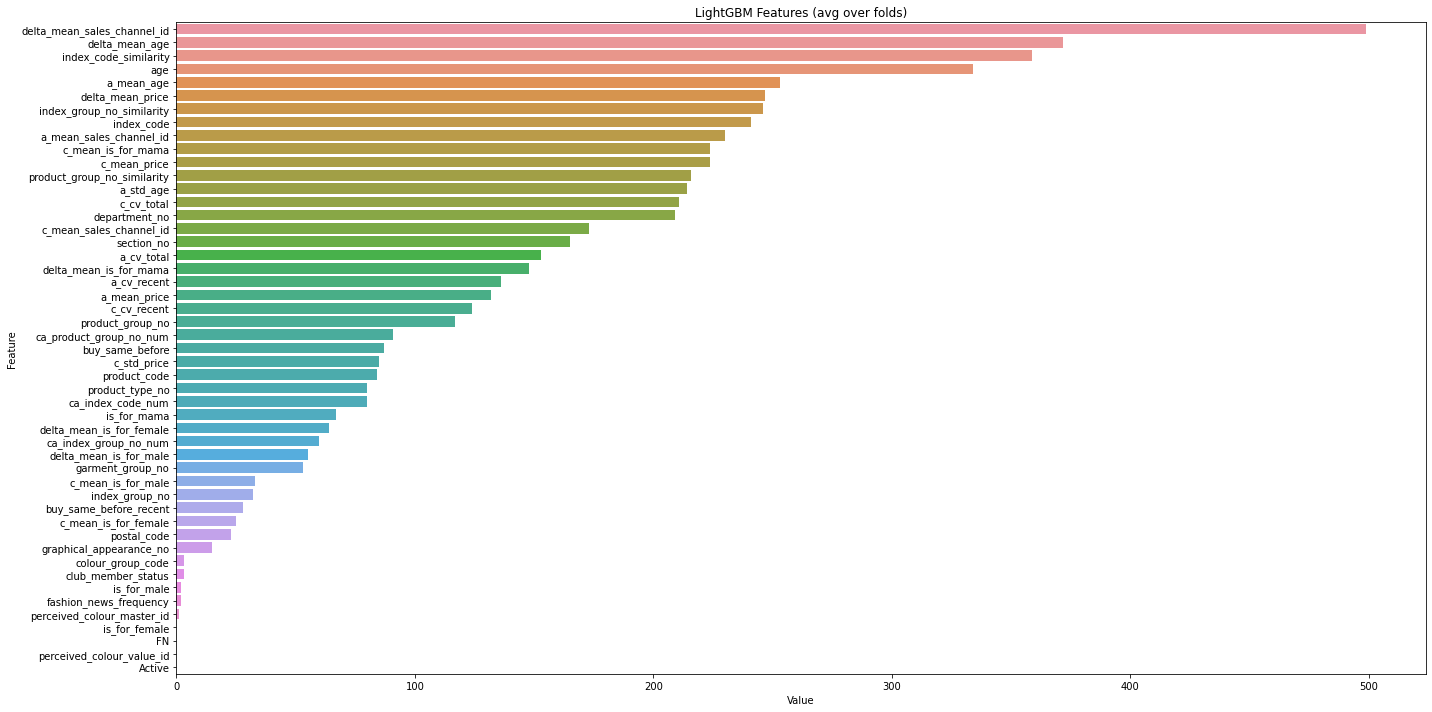

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name())), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

## test

In [24]:
# メモリ節約
del train, train_x, train_y, valid, valid_x, valid_y
gc.collect()

12307

In [25]:
# test data
Nval = 30
test = dd.read_csv(f'./test_{Nval}.csv', dtype=input_type).compute()
test

,customer_id,article_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,c_std_price,...,ca_product_group_no_num,product_group_no_similarity,buy_same_before,buy_same_before_recent,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,-7200416642310594310,924243001,False,False,0,2,25,57312,0.030258,0.016953,...,25,0.290698,0,0,-0.011246,-11,0.289062,0.011627,-0.023438,0.0
1,-7200416642310594310,918522001,False,False,0,2,25,57312,0.030258,0.016953,...,25,0.290698,0,0,-0.011169,-9,0.272461,0.011627,-0.023438,0.0
2,-7200416642310594310,866731001,False,False,0,2,25,57312,0.030258,0.016953,...,9,0.104651,0,0,0.005547,-5,0.166016,0.011627,-0.023438,0.0
3,-7200416642310594310,448509014,False,False,0,2,25,57312,0.030258,0.016953,...,9,0.104651,0,0,-0.010406,-5,-0.030273,0.011627,-0.023438,0.0
4,-7200416642310594310,909370001,False,False,0,2,25,57312,0.030258,0.016953,...,9,0.104651,0,0,-0.002575,-7,0.374023,0.011627,-0.023438,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133538,4901944553013920340,915529005,False,False,0,2,25,149161,0.032928,0.002825,...,0,0.000000,0,0,-0.000423,-7,0.125977,0.000000,0.000000,0.0
133539,4901944553013920340,923758001,False,False,0,2,25,149161,0.032928,0.002825,...,0,0.000000,0,0,-0.000541,-10,0.003906,0.000000,0.000000,0.0
133540,4901944553013920340,918292001,False,False,0,2,25,149161,0.032928,0.002825,...,0,0.000000,0,0,-0.008469,-6,0.273438,0.000000,0.000000,0.0
133541,4901944553013920340,934835001,False,False,0,2,25,149161,0.032928,0.002825,...,0,0.000000,0,0,0.008141,-4,0.000000,0.000000,0.000000,0.0


In [26]:
test.sort_index(inplace=True)

In [27]:
test_id = test[['customer_id', 'article_id']]
test = test.drop(['customer_id', 'article_id'], axis=1)

### prediction

In [28]:
del query_list_train, query_list_valid, lgb_train, lgb_eval, params, feature_imp
gc.collect()

0

In [29]:
test

,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,c_mean_price,c_std_price,c_cv_total,c_cv_recent,...,ca_product_group_no_num,product_group_no_similarity,buy_same_before,buy_same_before_recent,delta_mean_price,delta_mean_age,delta_mean_sales_channel_id,delta_mean_is_for_male,delta_mean_is_for_female,delta_mean_is_for_mama
0,False,False,0,2,25,57312,0.030258,0.016953,86,0,...,25,0.290698,0,0,-0.011246,-11,0.289062,0.011627,-0.023438,0.0
0,False,False,0,2,27,211349,0.033875,0.000000,1,0,...,0,0.000000,0,0,0.000393,-7,0.000000,0.000000,0.000000,0.0
0,True,True,0,4,29,131051,0.015656,0.005062,4,0,...,1,0.250000,0,0,-0.017700,-6,0.189453,0.000000,0.000000,0.0
0,False,False,0,2,19,61034,0.014557,0.006737,5,0,...,1,0.200000,1,0,0.006905,-11,0.098633,0.000000,0.000000,0.0
0,False,False,3,2,25,344775,0.023712,0.004795,2,0,...,2,1.000000,0,0,-0.018188,-11,0.002930,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133765,False,False,0,2,17,175159,0.011848,0.007191,2,0,...,0,0.000000,0,0,-0.029556,-14,0.273438,0.000000,0.000000,0.0
133766,False,False,0,2,17,175159,0.011848,0.007191,2,0,...,2,1.000000,0,0,-0.012939,-12,0.000000,0.000000,0.000000,0.0
133767,False,False,0,2,17,175159,0.011848,0.007191,2,0,...,2,1.000000,0,0,-0.013168,-17,0.309570,0.000000,0.000000,0.0
133768,False,False,0,2,17,175159,0.011848,0.007191,2,0,...,0,0.000000,0,0,-0.046600,-15,0.001953,0.000000,0.000000,0.0


In [30]:
pred = model.predict(test, num_iteration=100)
pred.shape, test.shape

((10682806,), (10682806, 49))

In [31]:
del test, model
gc.collect()

4

In [32]:
test_id = test_id.reset_index(drop=True)
pred = pd.Series(pred, name='score')

In [33]:
sub1 = pd.concat([test_id, pred], axis=1)

In [34]:
#sub1 = sub1[['customer_id', 'article_id', 'score']]

In [35]:
sub1

,customer_id,article_id,score
0,-7200416642310594310,924243001,-0.032479
1,-3505146687720672128,894780001,-0.048704
2,-963948248548795874,915529003,-0.057957
3,-16996662641422953,761328002,1.098092
4,2638212769247788115,924243002,-0.057342
...,...,...,...
10682801,855043037421715,918292001,-0.075210
10682802,855043037421715,934835001,0.058860
10682803,855043037421715,762846027,-0.073383
10682804,855043037421715,929275001,-0.102477


In [36]:
sub1 = sub1.sort_values(['customer_id','score'], ascending=False)

In [37]:
sub1 = sub1.groupby('customer_id')['article_id'].apply(list).reset_index(name='prediction')

In [38]:
sub1['prediction'].apply(len)

0         30
1         30
2         30
3         30
4         30
          ..
356089    30
356090    30
356091    30
356092    30
356093    30
Name: prediction, Length: 356094, dtype: int64

In [39]:
sub1['prediction'] = sub1['prediction'].apply(lambda x: x[:12])
sub1['prediction'].apply(len)

0         12
1         12
2         12
3         12
4         12
          ..
356089    12
356090    12
356091    12
356092    12
356093    12
Name: prediction, Length: 356094, dtype: int64

In [40]:
sub1['prediction']

0         [470985003, 934835001, 448509014, 788575002, 9...
1         [835008005, 915526001, 918522001, 835008001, 9...
2         [552716001, 909370001, 918522001, 915526001, 7...
3         [738943004, 918292001, 866731001, 915526001, 8...
4         [718748001, 715624001, 889550002, 911699002, 9...
                                ...                        
356089    [448509014, 918292001, 866731001, 889550002, 7...
356090    [473954013, 918292001, 866731001, 918522001, 9...
356091    [826252001, 924243002, 924243001, 918522001, 9...
356092    [918292001, 866731001, 918522001, 915526001, 8...
356093    [889550002, 715624001, 911699002, 788575002, 9...
Name: prediction, Length: 356094, dtype: object

In [41]:
# 提出用に元に戻す
sub1['prediction'] = sub1['prediction'].map(lambda x:'0'+' 0'.join(map(str, x)))

In [42]:
sub1

,customer_id,prediction
0,-9223319430705797669,0470985003 0934835001 0448509014 0788575002 09...
1,-9223293121067732640,0835008005 0915526001 0918522001 0835008001 09...
2,-9223251502792607675,0552716001 0909370001 0918522001 0915526001 07...
3,-9223225275836423258,0738943004 0918292001 0866731001 0915526001 08...
4,-9223211958423060038,0718748001 0715624001 0889550002 0911699002 09...
...,...,...
356089,9222994810437999589,0448509014 0918292001 0866731001 0889550002 07...
356090,9223078312300145319,0473954013 0918292001 0866731001 0918522001 09...
356091,9223103796055095238,0826252001 0924243002 0924243001 0918522001 09...
356092,9223104561489040694,0918292001 0866731001 0918522001 0915526001 08...


## Submit

In [43]:
sub = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
del sub['prediction']; gc.collect()
visualize_df(sub)

(1371980, 1)


,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...


In [44]:
sub['customer_id2'] = sub['customer_id'].apply(lambda x: int(x[-16:],16) ).astype('int64')

In [45]:
print(sub.shape, sub1.shape)

(1371980, 2) (356094, 2)


In [46]:
sub

,customer_id,customer_id2
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,6883939031699146327
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,-7200416642310594310
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,-6846340800584936
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,-94071612138601410
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,-283965518499174310
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,7551062398649767985
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,-9141402131989464905
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,-8286316756823862684
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,2551401172826382186


In [50]:
sub1

,customer_id,prediction
0,-9223319430705797669,0470985003 0934835001 0448509014 0788575002 09...
1,-9223293121067732640,0835008005 0915526001 0918522001 0835008001 09...
2,-9223251502792607675,0552716001 0909370001 0918522001 0915526001 07...
3,-9223225275836423258,0738943004 0918292001 0866731001 0915526001 08...
4,-9223211958423060038,0718748001 0715624001 0889550002 0911699002 09...
...,...,...
356089,9222994810437999589,0448509014 0918292001 0866731001 0889550002 07...
356090,9223078312300145319,0473954013 0918292001 0866731001 0918522001 09...
356091,9223103796055095238,0826252001 0924243002 0924243001 0918522001 09...
356092,9223104561489040694,0918292001 0866731001 0918522001 0915526001 08...


In [47]:
sub =  pd.merge(sub, sub1, left_on='customer_id2', right_on='customer_id', how='left')
#sub = sub.drop([['customer_id2', 'customer_id_y']], axis=1)

In [48]:
sub = sub[['customer_id_x', 'prediction']].copy()
sub.columns = ['customer_id', 'prediction']
print(sub.shape)

(1371980, 2)


In [49]:
sub

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0934835001 0896169005 0889550002 0924243002 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0924243002 0896169005 0915529005 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,NaN
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,NaN
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,NaN
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,NaN
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,NaN


In [ ]:
#sub = sub[['customer_id', 'valid_pred']].copy()
#sub.columns = ['customer_id', 'prediction']
print(sub.shape)

sub.to_csv('submission.csv', index=False)

(1371980, 2)
